# DACH Network EDA

### Introduction

In the following file, the subnetwork, DACH region, will be explored and clustered to gain further insights in the network. The imported csv is already filter to only DACH region and has all the relevant attributes merged to it.

We will apply two cluster methods on the DACH network:
- Louvain with the underlying network
- K-means with the financial data as attributes



## Read the csv files and inspect them as df

In [1]:
# Import packages
import pandas as pd
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import community as community_louvain
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Import csv files
# CIQ Data extract
CIQ_df = pd.read_csv('../Files/CIQ_data_DS_LAB_Preprocessed.csv')

# Network data
dach_df_2011 = pd.read_csv('../Files/labeled_network_2011_dach_20240114.csv')
dach_df_2013 = pd.read_csv('../Files/labeled_network_2013_dach_20240114.csv')
dach_df_2016 = pd.read_csv('../Files/labeled_network_2016_dach_20240114.csv')
dach_df_2022 = pd.read_csv('../Files/labeled_network_2022_dach_20240114.csv')

# Network Construction

In [3]:
def calculate_edge_weights(df, impacts):
    # Create a dictionary to hold the edge weights
    edge_weights = {}

    for label in impacts.keys():
        # Filter for entries with the current label
        label_edges = df[df['label'] == label]

        # Iterate through each attribute of this label
        for attribute in label_edges['attribute'].unique():
            companies_with_attribute = label_edges[label_edges['attribute'] == attribute]['company'].unique()
            
            # Create edges between all pairs of companies sharing this attribute
            for i in range(len(companies_with_attribute)):
                for j in range(i + 1, len(companies_with_attribute)):
                    edge = tuple(sorted([companies_with_attribute[i], companies_with_attribute[j]]))
                    edge_weights[edge] = edge_weights.get(edge, 0) + impacts[label]

    # Convert the edge_weights dictionary to a DataFrame
    edges_df = pd.DataFrame([(src, tgt, wt) for (src, tgt), wt in edge_weights.items()], 
                            columns=['source', 'target', 'weight'])

    return edges_df

# Testing the function with the 2011 data and the impact percentages
impact_percentages = {
    'person': 0.3,
    'country': 0.1,
    'city': 0.1,
    'exchange': 0.2,
    'gpe': 0.2,
    'org': 0.1,
}

edges_weighted_df_2011 = calculate_edge_weights(dach_df_2011, impact_percentages)
edges_weighted_df_2013 = calculate_edge_weights(dach_df_2013, impact_percentages)
edges_weighted_df_2016 = calculate_edge_weights(dach_df_2016, impact_percentages)
edges_weighted_df_2022 = calculate_edge_weights(dach_df_2022, impact_percentages)

In [4]:
def build_graph_with_attributes_and_weighted_edges(df, edges_df):
    G = nx.Graph()

    # Add nodes with their non-weight attributes
    for company in df['company'].unique():
        # Add attributes from the dataframe to the node attributes dictionary
        company_attributes = df[df['company'] == company].set_index('label')['attribute'].to_dict()
        
        # Add node to the graph with all attributes (excluding weights)
        G.add_node(company, **company_attributes)

    # Add weighted edges to the graph
    for _, row in edges_df.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['weight'])

    return G

# Build the graph with the 2011 data and the new edges with weights
dach_2011_graph = build_graph_with_attributes_and_weighted_edges(dach_df_2011, edges_weighted_df_2011)
dach_2013_graph = build_graph_with_attributes_and_weighted_edges(dach_df_2013, edges_weighted_df_2013)
dach_2016_graph = build_graph_with_attributes_and_weighted_edges(dach_df_2016, edges_weighted_df_2016)
dach_2022_graph = build_graph_with_attributes_and_weighted_edges(dach_df_2022, edges_weighted_df_2022)

In [5]:
def visualize_and_export_network(G, export_gexf=False, gexf_path='exported_network.gexf'):
    # Calculate positions for all nodes in the original network
    pos = nx.spring_layout(G)

    # Settings for the plot
    plt.figure(figsize=(12, 8))
    node_scale = 50
    edge_scale = 0.5

    # Plot the original network
    plt.title('Original Network', fontsize=20)
    nx.draw_networkx_nodes(G, pos, node_size=node_scale, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.show()
    print(f"Original Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Export to GEXF if requested for Gephi
    if export_gexf:
        nx.write_gexf(G, gexf_path)
        print(f"Exported the backbone network to {gexf_path}")


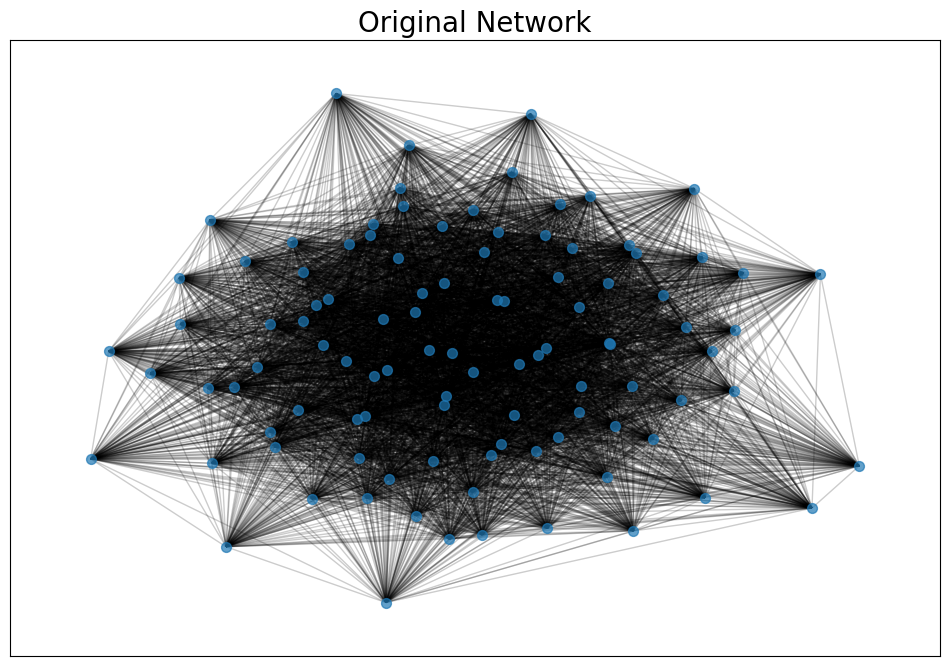

Original Network: 102 nodes, 5150 edges
Exported the backbone network to dach_df_2011.gexf


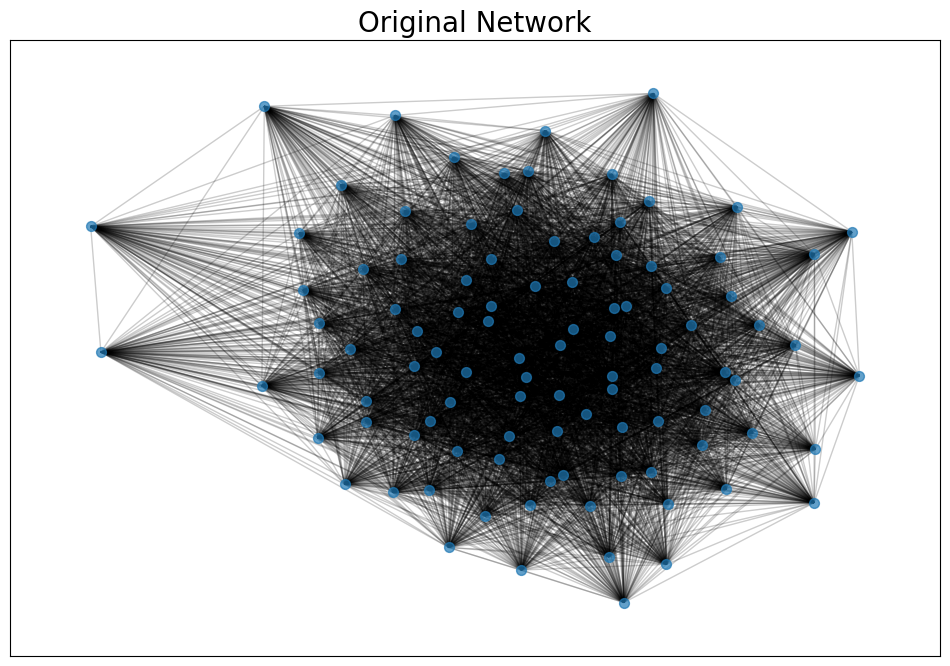

Original Network: 100 nodes, 4950 edges
Exported the backbone network to dach_df_2013.gexf


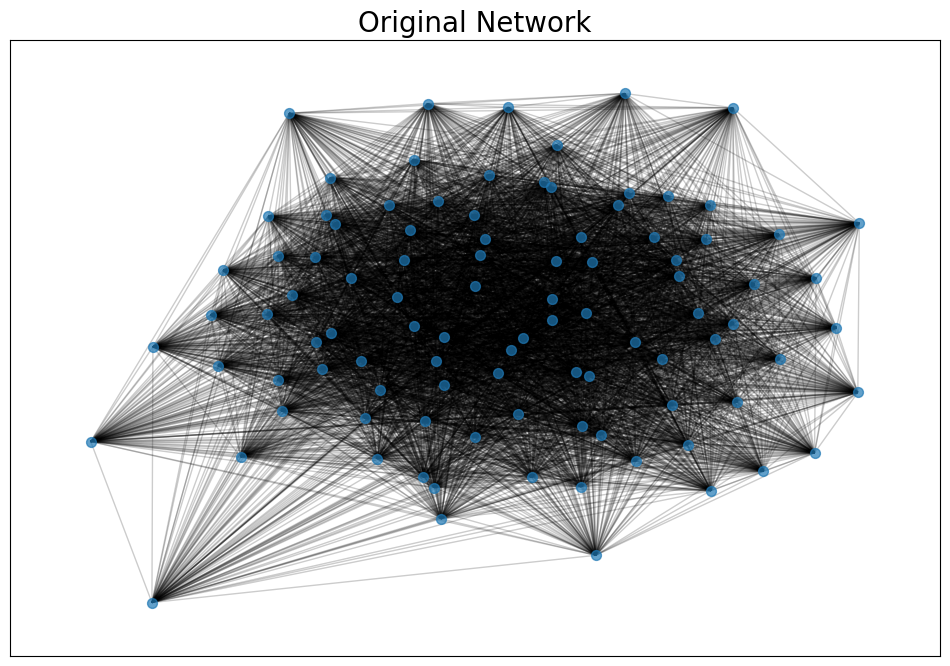

Original Network: 97 nodes, 4656 edges
Exported the backbone network to dach_df_2016.gexf


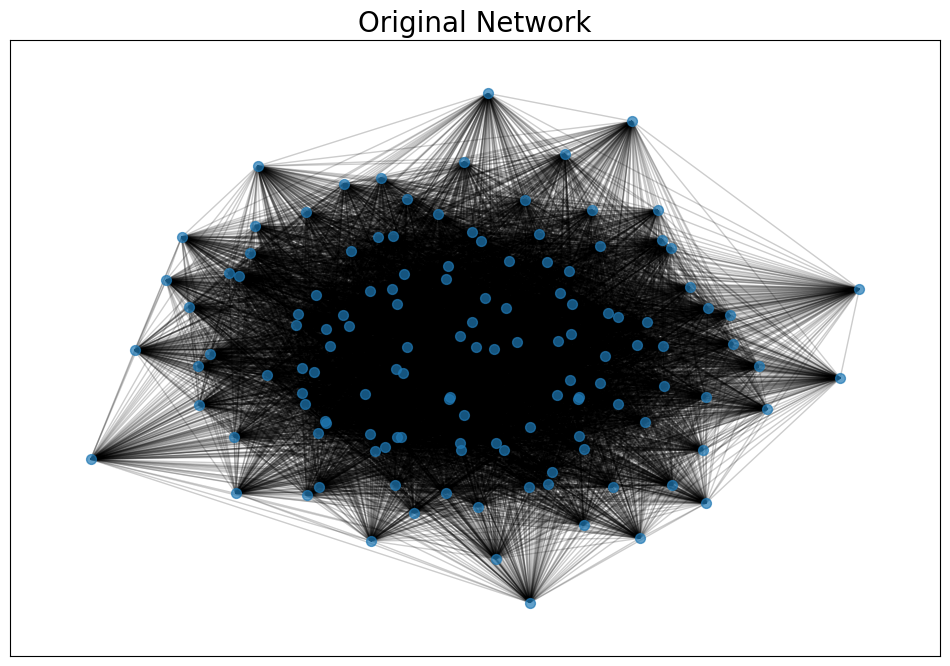

Original Network: 131 nodes, 8515 edges
Exported the backbone network to dach_df_2022.gexf


In [6]:
visualize_and_export_network(dach_2011_graph, export_gexf=True, gexf_path='dach_df_2011.gexf')
visualize_and_export_network(dach_2013_graph, export_gexf=True, gexf_path='dach_df_2013.gexf')
visualize_and_export_network(dach_2016_graph, export_gexf=True, gexf_path='dach_df_2016.gexf')
visualize_and_export_network(dach_2022_graph, export_gexf=True, gexf_path='dach_df_2022.gexf')

# Clustering

In [18]:
def apply_louvain_and_export(G, export_graphs=False, seed=1):
    # Set the random seed for reproducibility
    random.seed(seed)

    # Compute the best partition
    partition = community_louvain.best_partition(G, random_state=seed)

    # Drawing the entire network with community coloring
    pos = nx.spring_layout(G, seed=seed)  # Using the same seed for layout
    cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
    plt.figure(figsize=(8, 8))
    for com in set(partition.values()):
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size=20, node_color=[cmap(com)])
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

    # Create and export individual subgraphs for each community
    for i, com in enumerate(set(partition.values())):
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        subgraph = G.subgraph(list_nodes)
        plt.figure(figsize=(6, 6))
        nx.draw(subgraph, with_labels=True, node_color=[cmap(i) for n in subgraph])
        plt.title(f"Community {i}")
        if export_graphs:
            # Export the community graph to GEXF format
            nx.write_gexf(subgraph, f'Community2011_{i}.gexf')
        else:
            # Show the plot for the community
            plt.show()

/var/folders/c5/p91g9dqd01qgp3n2r632ljcw0000gn/T/ipykernel_88193/2096895697.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


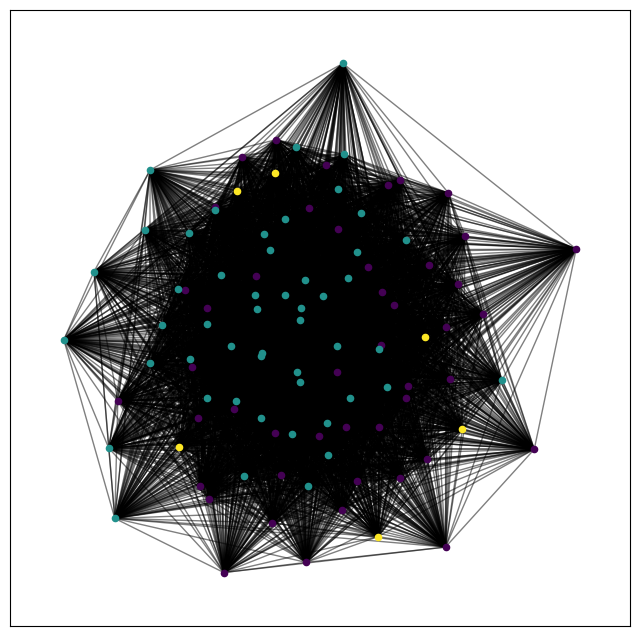

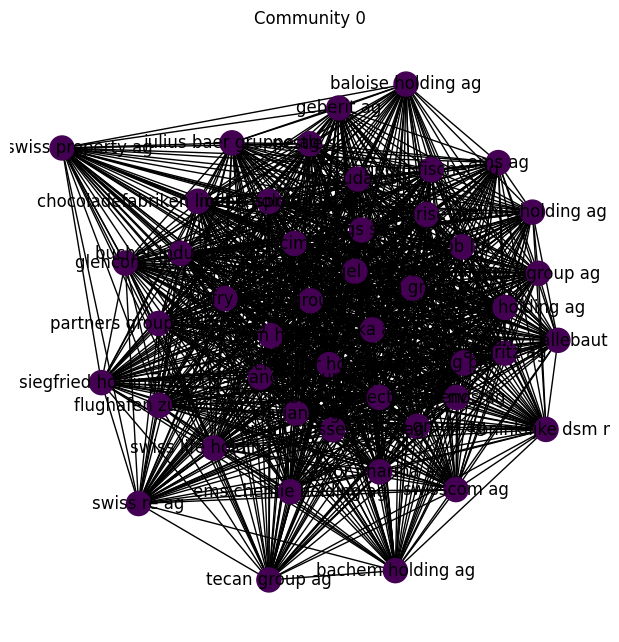

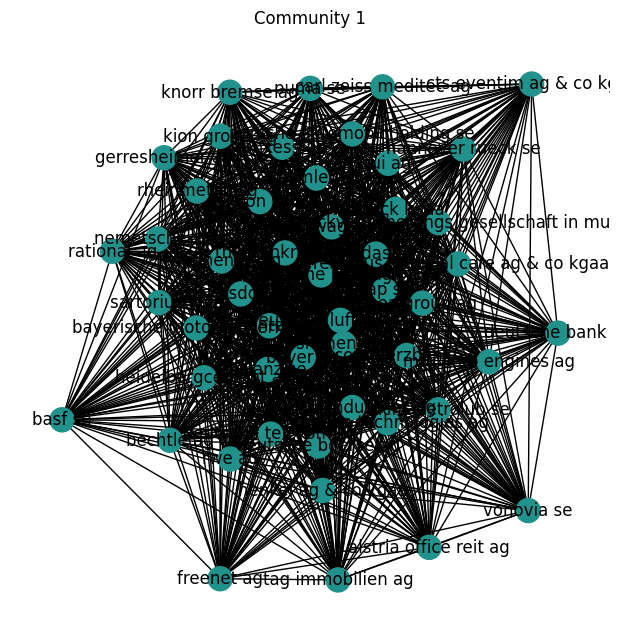

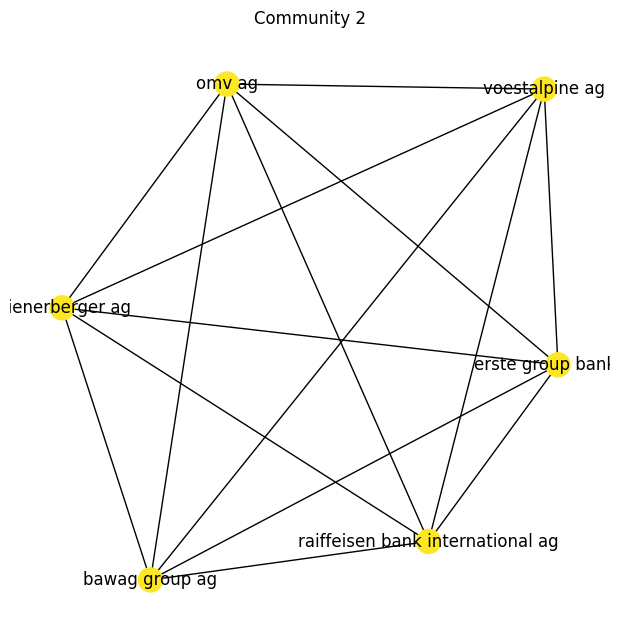

In [19]:
# Apply Louvain method on graph and export for gephi
apply_louvain_and_export(dach_2011_graph, export_graphs=True)
apply_louvain_and_export(dach_2013_graph, export_graphs=True)
apply_louvain_and_export(dach_2016_graph, export_graphs=True)
apply_louvain_and_export(dach_2022_graph, export_graphs=True)

# Statistics on Network Clusters

In [17]:
# Function for import of graphs
def import_network_gexf(file_path):
    return nx.read_gexf(file_path)

# Function to rename the column names
def rename_columns(stats_df, renaming_dict):
    # Rename columns
    return stats_df.rename(columns=renaming_dict)

In [18]:
# Import communities again - attention: differentiate between names
# 2011
comm1_2011= import_network_gexf("Community_1.gexf")
comm2_2011= import_network_gexf("Community_2.gexf")
comm3_2011= import_network_gexf("Community_3.gexf")

# 2013
comm1_2013= import_network_gexf("Community_1.gexf")
comm2_2013= import_network_gexf("Community_2.gexf")
comm3_2013= import_network_gexf("Community_3.gexf")

# 2016
comm1_2016= import_network_gexf("Community_1.gexf")
comm2_2016= import_network_gexf("Community_2.gexf")
comm3_2016= import_network_gexf("Community_3.gexf")

# 2022
comm1_2022= import_network_gexf("Community_1.gexf")
comm2_2022= import_network_gexf("Community_2.gexf")
comm3_2022= import_network_gexf("Community_3.gexf")


# Financials

For the following part, we calculate statistics about the networks. The functions are not activated for all the different networks since it would make the file to large. As an illustration we display the network 2011 with all the clusters for Louvain and Kmeans. To create new metrics and export graphs, the function can simply take the other networks as an input.

In [22]:
def financial_stats_by_node(network, financial_attributes, ratio_attributes):
    
    # Initialize a dictionary to hold financial data for each attribute
    financial_stats = {}

    for attribute in financial_attributes + ratio_attributes:
        # Extract all values for this attribute from the network's nodes, ignoring N/As
        values = [data.get(attribute, np.nan) for node, data in network.nodes(data=True)]
        
        # Convert all values to a pandas Series for numeric operations and handling N/As
        values = pd.Series(values).replace('NM', np.nan)
        values = pd.to_numeric(values, errors='coerce')
        values = values.dropna()

        # Calculate statistics
        if attribute in ratio_attributes:
            # For ratios and margins, assume they are already in the correct format
            financial_stats[attribute] = {
                'Average': f"{values.mean():.2f}%",
                'Min': f"{values.min():.2f}%",
                'Max': f"{values.max():.2f}%",
                'Variance': f"{values.var():.2f}%"
            }
        else:
            # Convert other financial metrics to thousands for representation
            values_k = values / 1000
            financial_stats[attribute] = {
                'Average': f"{values_k.mean():.2f}k",
                'Min': f"{values_k.min():.2f}k",
                'Max': f"{values_k.max():.2f}k",
                'Variance': f"{(values_k.var()):.2f}k"
            }

    # Convert the stats dictionary to a DataFrame for better visualization
    stats_df = pd.DataFrame(financial_stats).T
    stats_df = stats_df[['Average', 'Min', 'Max', 'Variance']]

    return stats_df

# Assuming 'dach_2011' is your graph with the financial data
# Define financial and ratio attributes according to your dataset's attributes
ratio_attributes = ['iq_ebitda_margin', 'iq_ni_margin', 'iq_return_assets', 'iq_return_equity', 'iq_total_debt_equity', 'iq_gross_margin']

financial_attributes = [
    'iq_capex', 'iq_cash_oper', 'iq_cogs', 'iq_cost_rev', 'iq_curr_taxes', 
    'iq_ebitda', 'iq_gp', 'iq_int_exp_ltd', 'iq_marketcap', 
    'iq_net_debt', 'iq_ni', 'iq_oper_inc', 'iq_total_assets', 'iq_total_debt_capital', 
    'iq_total_equity', 'iq_total_liab', 'iq_total_rev'
]

# Calculate the financial statistics for the Dach network
financial_stats_by_node(dach_2011_graph, financial_attributes, ratio_attributes)


Average       Min       Max   Variance
iq_capex               -0.83k    -8.09k     0.00k      2.33k
iq_cash_oper            1.16k   -58.37k    38.84k     64.16k
iq_cogs                13.40k     0.00k   181.94k    718.01k
iq_cost_rev            13.80k     0.00k   181.94k    774.69k
iq_curr_taxes           0.38k    -0.04k     4.35k      0.49k
iq_ebitda               2.49k    -0.03k    16.97k     15.34k
iq_gp                   5.88k     0.00k    39.64k     69.83k
iq_int_exp_ltd          0.13k     0.00k     5.66k      0.40k
iq_marketcap           13.21k     0.00k   166.96k    582.04k
iq_net_debt             4.33k  -213.65k   167.77k    972.48k
iq_ni                   1.13k    -2.22k    15.41k      5.46k
iq_oper_inc             1.83k    -0.12k    13.52k      7.86k
iq_total_assets        96.28k     0.16k  2164.10k  82305.24k
iq_total_debt_capital   0.03k     0.00k     0.11k      0.00k
iq_total_equity        10.29k    -0.49k    63.35k    213.78k
iq_total_liab          85.99k     0.06k  2109.44k  77169.83k
iq_total_rev           19.67k     0.00k   186.15k   1061.23k
iq_ebitda_margin       17.90%    -0.43%    80.03%    206.79%
iq_ni_margin            9.91%   -14.25%   138.67%    261.52%
iq_return_assets        5.22%    -0.27%    21.25%     17.64%
iq_return_equity       14.63%    -6.73%    73.01%    116.03%
iq_total_debt_equity   68.31%     0.00%  1040.40%  12812.36%
iq_gross_margin        36.91%     0.00%    92.47%    528.97%

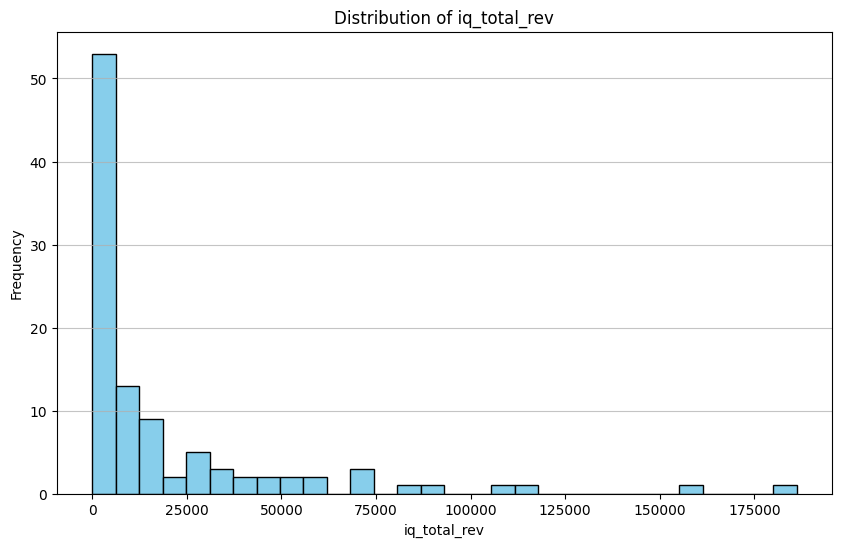

In [233]:
def plot_financial_attribute_distribution(network, financial_attribute):
    # Extract the specified financial attribute from all nodes (companies) in the network
    values = [data.get(financial_attribute, None) for node, data in network.nodes(data=True)]

    # Convert values to numeric, replacing 'NM' and 'N/A' with NaN and dropping them
    values = pd.Series(values).replace('NM', np.nan).replace('N/A', np.nan)
    values = pd.to_numeric(values, errors='coerce').dropna()

    # Plotting the distribution of the financial attribute
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {financial_attribute}")
    plt.xlabel(financial_attribute)
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Assuming 'network_graph_with_attributes' is your graph with the financial data
# Specify the financial attribute you are interested in, for example 'iq_total_rev'
plot_financial_attribute_distribution(dach_2011, 'iq_total_rev')


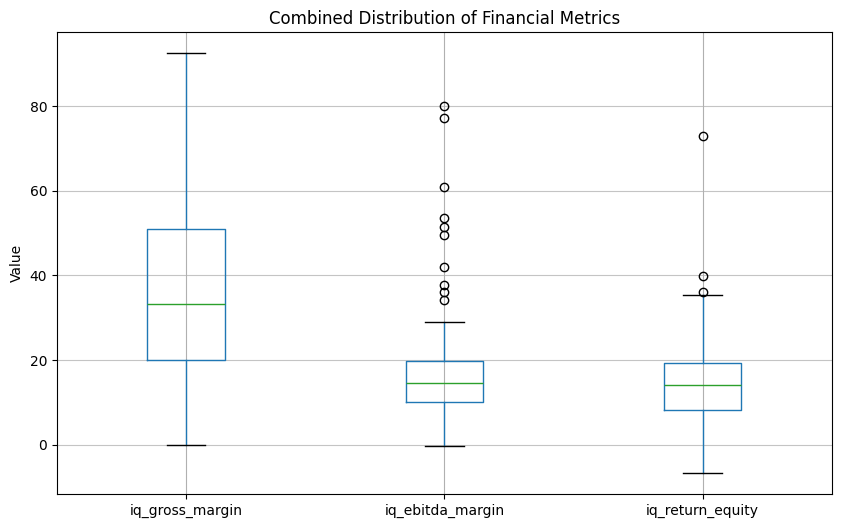

In [240]:
def plot_combined_boxplot(network, financial_attributes):
    # Extract and clean data for all attributes
    data = {}
    for attribute in financial_attributes:
        values = [data.get(attribute, None) for node, data in network.nodes(data=True)]
        values = pd.Series(values).replace(['NM', 'N/A', None], np.nan)
        data[attribute] = pd.to_numeric(values, errors='coerce').dropna()
    
    # Combine data into a DataFrame for boxplot
    combined_df = pd.DataFrame(data)

    # Plotting
    plt.figure(figsize=(10, 6))
    combined_df.boxplot()
    plt.title("Combined Distribution of Financial Metrics")
    plt.ylabel("Value")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Call the function with the network graph and a list of financial attributes
#plot_combined_boxplot(dach_2011, ['iq_total_rev', 'iq_cogs', 'iq_ebitda'])
plot_combined_boxplot(dach_2011, ['iq_gross_margin', 'iq_ebitda_margin', 'iq_return_equity'])


## Community 1

In [318]:
financial_stats_by_node(comm1_2011, financial_attributes, ratio_attributes)

Average       Min       Max    Variance
iq_capex                -0.94k    -6.35k     0.00k       2.83k
iq_cash_oper             0.55k   -58.37k    16.64k     105.16k
iq_cogs                 13.87k     0.00k    97.84k     467.63k
iq_cost_rev             14.23k     0.00k    97.84k     492.57k
iq_curr_taxes            0.39k    -0.04k     2.87k       0.35k
iq_gp                    5.84k     0.00k    31.39k      54.14k
iq_int_exp_ltd           0.12k     0.00k     2.65k       0.20k
iq_marketcap            10.82k     0.00k    48.61k     170.77k
iq_net_debt              4.18k  -213.65k   167.77k    2006.56k
iq_ni                    0.71k    -2.22k     4.88k       1.63k
iq_oper_inc              1.67k    -0.07k     7.91k       4.49k
iq_total_assets        113.59k     0.16k  2164.10k  128525.19k
iq_total_debt_capital    0.03k     0.00k     0.08k       0.00k
iq_total_equity         10.52k     0.10k    54.66k     194.46k
iq_total_liab          103.07k     0.06k  2109.44k  121613.94k
iq_total_rev            20.07k     0.00k   113.47k     719.63k
iq_ni_margin             8.67%    -3.02%    47.91%     101.63%
iq_return_assets         5.58%    -0.15%    21.25%      20.19%
iq_return_equity        14.49%    -4.40%    39.76%      91.58%
iq_total_debt_equity    67.29%     0.00%   300.28%    4516.94%
iq_gross_margin         34.79%     0.00%    91.03%     461.19%

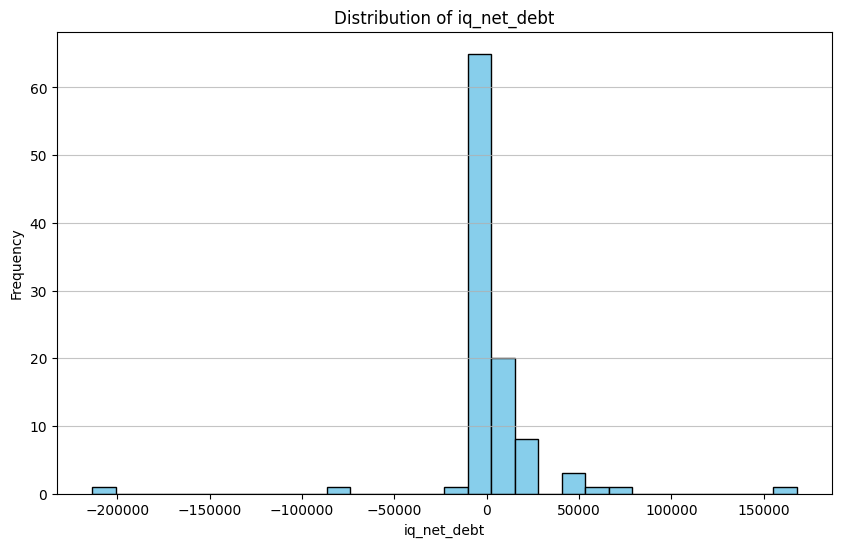

In [243]:
plot_financial_attribute_distribution(dach_2011, 'iq_net_debt')

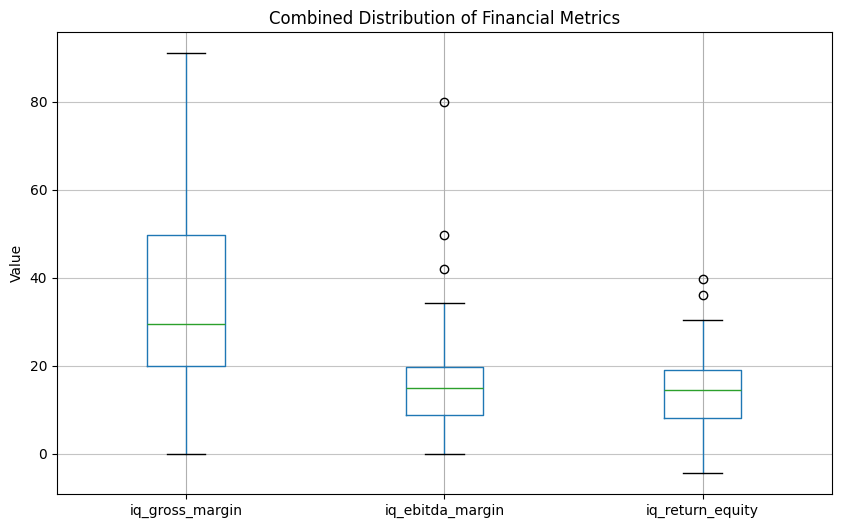

In [239]:
plot_combined_boxplot(comm1_2011, ['iq_gross_margin', 'iq_ebitda_margin', 'iq_return_equity'])

### Community 2

In [245]:
financial_stats_by_node(comm2_2011, financial_attributes, ratio_attributes)

Average      Min      Max
iq_capex               -0.88k   -8.09k    0.00k
iq_cash_oper            0.91k   -1.92k    8.50k
iq_cogs                22.71k    0.00k  181.94k
iq_cost_rev            23.65k    0.00k  181.94k
iq_curr_taxes           0.40k   -0.00k    4.35k
iq_ebitda               2.34k    0.15k   16.69k
iq_gp                   4.15k    0.24k   27.11k
iq_int_exp_ltd          0.08k    0.00k    0.85k
iq_marketcap            8.84k    0.00k   50.28k
iq_net_debt            10.19k   -1.18k   70.88k
iq_ni                   1.56k   -0.72k   15.41k
iq_oper_inc             1.50k    0.03k   11.10k
iq_total_assets        71.67k    0.73k  253.77k
iq_total_debt_capital   0.03k    0.00k    0.11k
iq_total_equity        11.50k   -0.49k   63.35k
iq_total_liab          60.17k    0.14k  214.87k
iq_total_rev           27.80k    0.29k  186.15k
iq_ebitda_margin       22.26%    2.38%   77.24%
iq_ni_margin           17.96%  -14.25%  138.67%
iq_return_assets        3.28%   -0.27%   16.77%
iq_return_equity       13.14%   -3.54%   35.37%
iq_total_debt_equity   43.75%    0.00%  147.63%
iq_gross_margin        36.68%    0.00%   88.81%

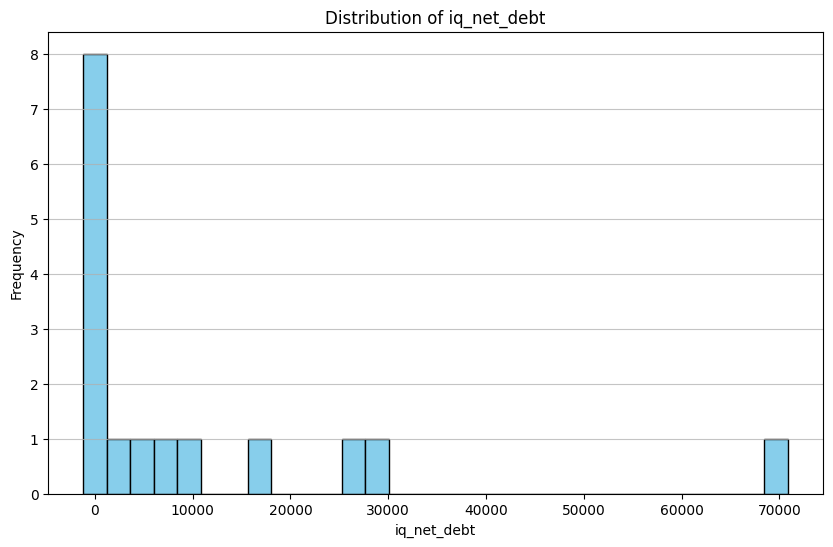

In [253]:
plot_financial_attribute_distribution(comm2_2011, 'iq_net_debt')

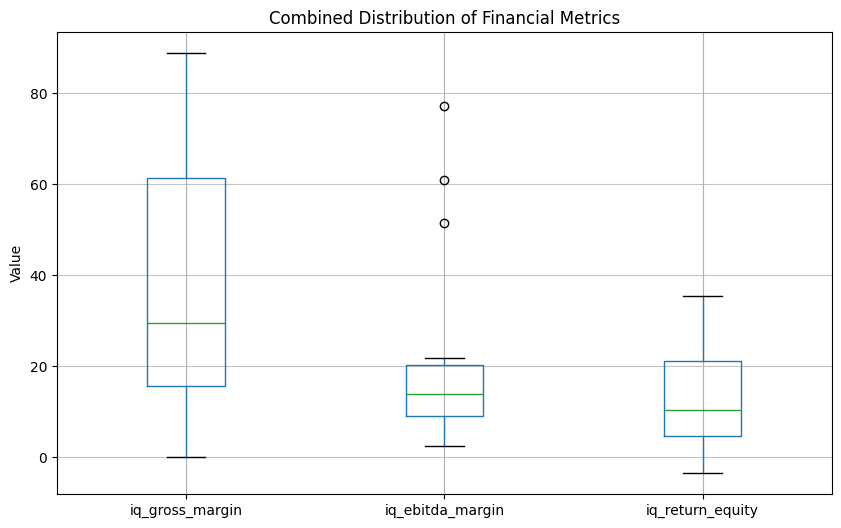

In [254]:
plot_combined_boxplot(comm2_2011, ['iq_gross_margin', 'iq_ebitda_margin', 'iq_return_equity'])

# Community 3

In [256]:
financial_stats_by_node(comm3_2011, financial_attributes, ratio_attributes)

Average      Min       Max        Variance
iq_capex               -0.73k   -4.78k    -0.01k      1335382.63
iq_cash_oper            1.84k  -14.24k    38.84k     50344251.78
iq_cogs                 9.87k    0.00k    71.15k    285082718.17
iq_cost_rev            10.11k    0.00k    81.93k    318441929.62
iq_curr_taxes           0.36k    0.00k     2.70k       433072.91
iq_ebitda               2.63k   -0.03k    15.89k     18152584.47
iq_gp                   6.67k    0.04k    39.64k     96138178.57
iq_int_exp_ltd          0.15k    0.00k     5.66k       730284.13
iq_marketcap           17.30k    0.00k   166.96k   1116119582.60
iq_net_debt             2.44k  -78.48k    52.10k    277926338.33
iq_ni                   1.39k   -0.03k     9.49k      5760082.29
iq_oper_inc             2.13k   -0.12k    13.52k     11310022.44
iq_total_assets        91.26k    0.30k  1416.96k  69835017493.70
iq_total_debt_capital   0.03k    0.00k     0.09k          485.37
iq_total_equity         9.86k    0.23k    58.27k    214338265.16
iq_total_liab          81.40k    0.07k  1368.43k  64939281033.39
iq_total_rev           16.79k    0.15k   106.54k    635198798.78
iq_ebitda_margin       16.46%   -0.43%    53.52%           97.77
iq_ni_margin            8.17%   -5.97%    21.18%           34.06
iq_return_assets        5.54%   -0.13%    14.33%           14.44
iq_return_equity       14.98%   -6.73%    73.01%          137.60
iq_total_debt_equity   76.77%    0.00%  1040.40%        24683.45
iq_gross_margin        39.08%    0.00%    92.47%          483.07

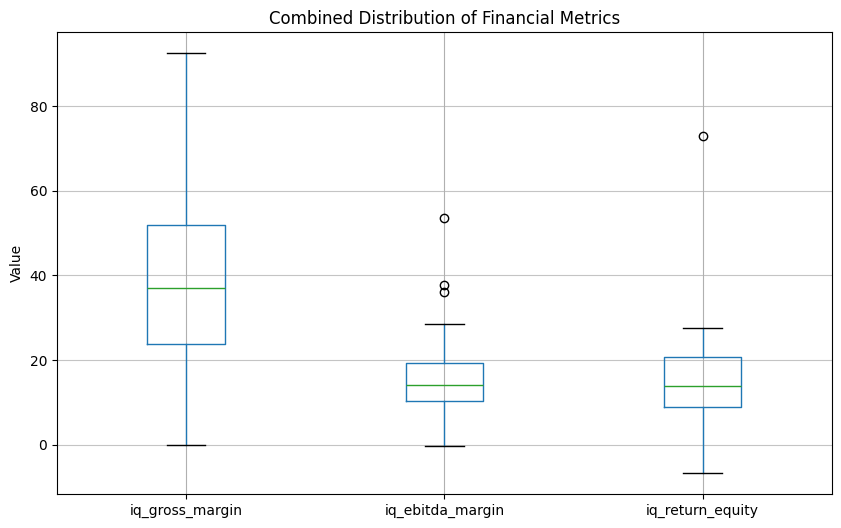

In [258]:
plot_combined_boxplot(comm3_2011, ['iq_gross_margin', 'iq_ebitda_margin', 'iq_return_equity'])

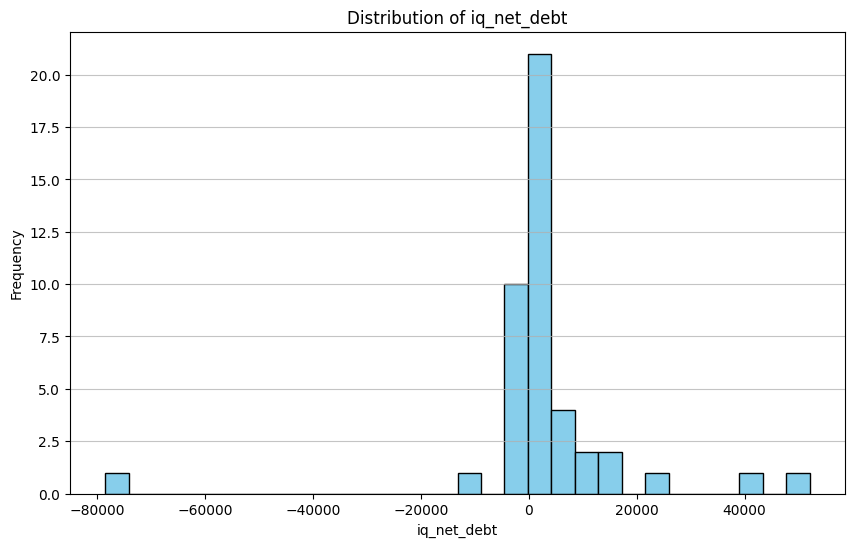

In [255]:
plot_financial_attribute_distribution(comm3_2011, 'iq_net_debt')

# Clustering - ML K-Means

 As a second clustering we choose the k-means where we take the finacial metrics calculated before and create clusters based on them - a cluster id will then be added to the respective companies to create multiple clusters.
 
To choose the correct number of clusters, we consider the elbow method for a reasonable cut. However, first we must clean the dataframe created before.

### First, we extract the financial data to a df

Here we lose 9 companies due to NA values in the data - we found out that 8 out of 9 companies dropped are because of missing edbitda and ebitda margin. To retain those 8 companies, we drop column ebitda and ebitda margin and only then we drop all NAs such that only one company (kion group ag) is lost.

In [23]:
def extract_financial_data(network, financial_attributes, ratio_attributes):
    financial_data = []
    for node, data in network.nodes(data=True):
        # Convert to numeric
        # Exclude 'iq_ebitda' and 'iq_ebitda_margin' from the data extraction
        node_data = {
            attr: pd.to_numeric(data.get(attr, pd.NA), errors='coerce')
            for attr in financial_attributes + ratio_attributes if attr not in ['iq_ebitda', 'iq_ebitda_margin']
        }
        node_data['company'] = node  # Keep track of the company name
        financial_data.append(node_data)

    # Convert to DataFrame and drop rows with missing data
    return pd.DataFrame(financial_data).dropna()

# Ensure that columns are not in the list anymore
financial_attributes = [attr for attr in financial_attributes if attr not in ['iq_ebitda', 'iq_ebitda_margin']]
ratio_attributes = [attr for attr in ratio_attributes if attr not in ['iq_ebitda', 'iq_ebitda_margin']]

# Extract financial data from the network graph
financial_df2011 = extract_financial_data(dach_2011_graph, financial_attributes, ratio_attributes)
financial_df2013 = extract_financial_data(dach_2013_graph, financial_attributes, ratio_attributes)
financial_df2016 = extract_financial_data(dach_2016_graph, financial_attributes, ratio_attributes)
financial_df2022 = extract_financial_data(dach_2022_graph, financial_attributes, ratio_attributes)
# View the resulting DataFrame
financial_df2011

iq_capex  iq_cash_oper     iq_cogs  iq_cost_rev  iq_curr_taxes  \
0   -1021.000      3612.000   26556.000    26556.000       1278.000   
1    -109.000       524.000   16979.000    16979.000        218.000   
2    -318.000       807.000    6993.000     6993.000        289.000   
3   -1201.000     16642.000   75037.000    75037.000       1797.000   
4       0.000        38.457       9.316        9.316          0.000   
..        ...           ...         ...          ...            ...   
97   -467.155       957.620    8519.672     8519.672        163.600   
98  -8087.000      8500.000  117117.000   132231.000       4351.000   
99     -1.300       585.000     532.500      532.500         -1.600   
100  -115.155       163.976    1301.389     1301.389         16.055   
101  -199.000      3889.000   39391.000    39391.000       1099.000   

         iq_gp  iq_int_exp_ltd  iq_marketcap  iq_net_debt      iq_ni  ...  \
0    11434.000           0.000   40492.81687    -1770.000   3168.000  ...   
1     3566.000           0.000    7584.67110      878.000    519.000  ...   
2     6329.000           0.000   10515.20551      -80.000    613.000  ...   
3    15350.000         886.700   33433.09685    17307.000   2545.000  ...   
4       94.546          17.869     659.38654      803.612     27.448  ...   
..         ...             ...           ...          ...        ...  ...   
97    2434.023           0.000    3656.76795     2730.834    584.759  ...   
98   27106.000          58.000   50280.08609    70884.000  15409.000  ...   
99     801.800           5.100       0.00000     6417.200    423.000  ...   
100    614.011           0.000     806.24895      395.374     40.168  ...   
101  13586.000         586.000   31022.32675     5311.000   3750.000  ...   

     iq_total_debt_capital  iq_total_equity  iq_total_liab  iq_total_rev  \
0                  19.6576        16336.000      23312.000     37990.000   
1                  27.2571         3811.000       5543.000     20545.000   
2                  20.1121         5128.000       6109.000     13322.000   
3                  36.7116        47253.000     594219.000     90387.000   
4                  53.9326          768.195        918.442       103.862   
..                     ...              ...            ...           ...   
97                 48.5003         4691.113       8385.334     10953.695   
98                 59.6178        63354.000     190415.000    159337.000   
99                 75.0176         2229.800       8153.200      1334.300   
100                27.7708         2430.819       1560.534      1915.400   
101                29.4668        33973.000     352998.000     52977.000   

     iq_ni_margin  iq_return_assets  iq_return_equity  iq_total_debt_equity  \
0          8.3390            7.6998           20.7963               24.4674   
1          2.5261            5.2309           14.0959               37.4704   
2          4.6014            5.2905           12.4705               25.1755   
3          2.8156            0.6480            5.9777               58.0068   
4         26.4273            3.1982            3.7584              117.0732   
..            ...               ...               ...                   ...   
97         5.3384            4.8197           13.2809               94.1759   
98         9.6706            3.0618           28.1976              147.6339   
99        31.7020            3.9367           20.9298              300.2825   
100        2.0971            0.5049            1.5908               38.4481   
101        7.0785            0.9313           11.2329               41.7772   

     iq_gross_margin                    company  
0            30.0973                    abb ltd  
1            17.3570            adecco group ag  
2            47.5078                  adidas ag  
3            16.9825                 allianz se  
4            91.0304     alstria office reit ag  
..               ...                        ...  
97           22

### Determine the optimal amount of clusters

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

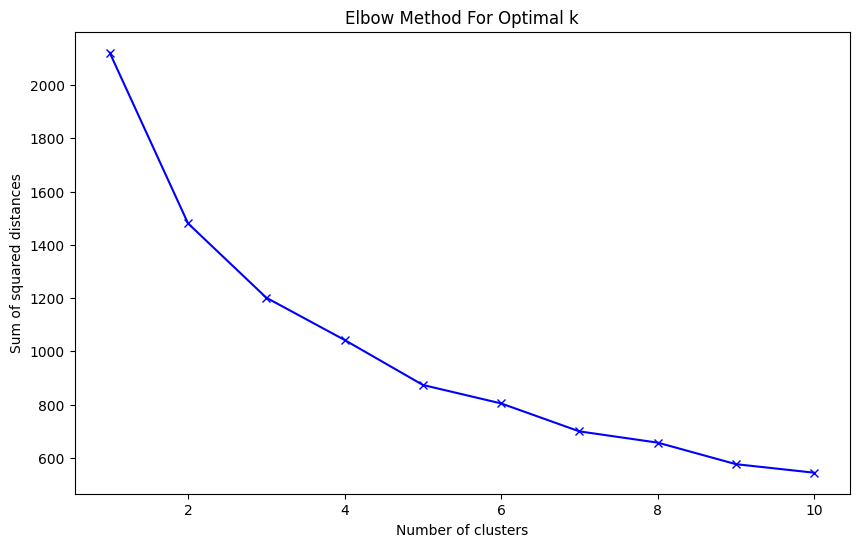

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

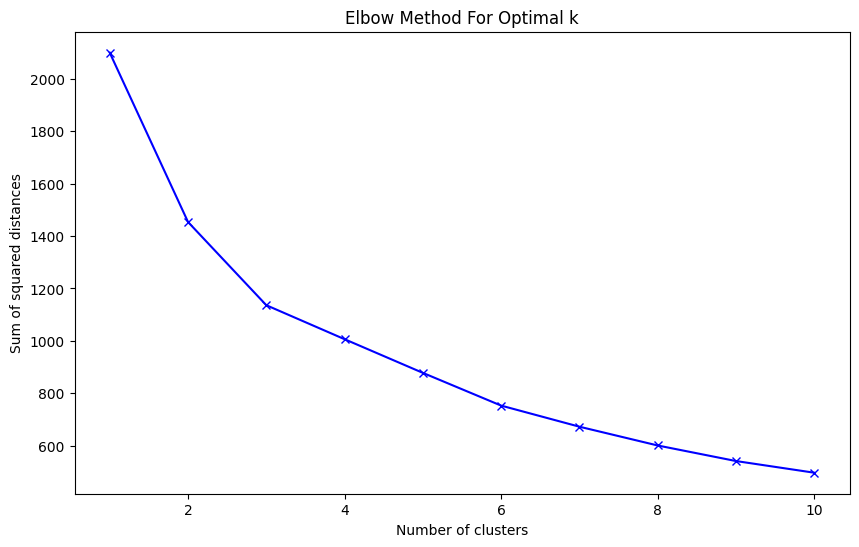

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

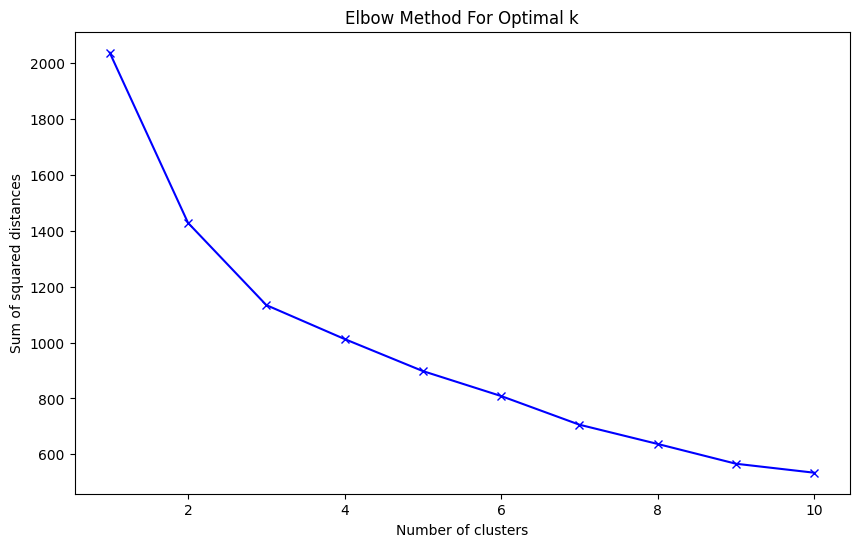

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

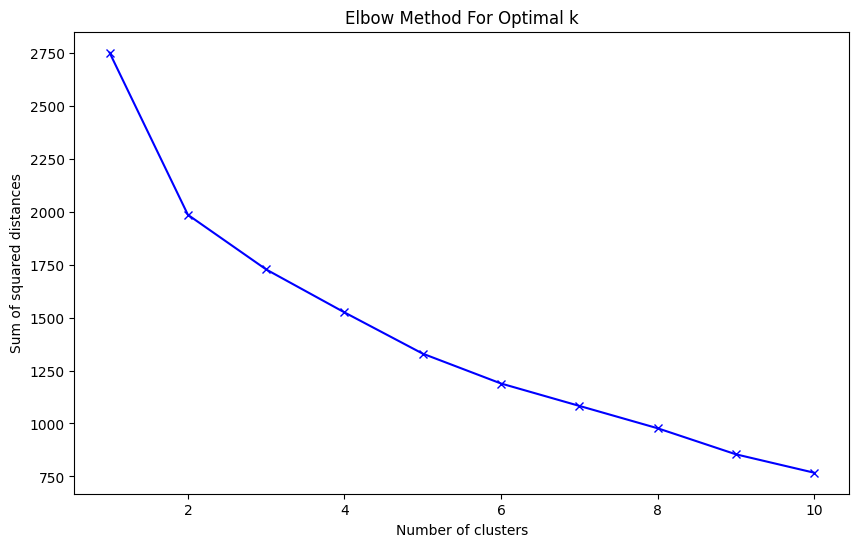

In [24]:
def determine_optimal_clusters(financial_data, max_clusters=10):
    
    # Automatically detect and retain only numeric columns for clustering
    numeric_columns = financial_data.select_dtypes(include=[np.number]).columns
    X_numeric = financial_data[numeric_columns]

    # Prepare the data by scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    
    # Calculate the sum of squared distances for different numbers of clusters (k)
    sse = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        sse.append(kmeans.inertia_)
    
    # Plot the elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters+1), sse, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# Apply to dataframe
determine_optimal_clusters(financial_df2011, max_clusters=10)
determine_optimal_clusters(financial_df2013, max_clusters=10)
determine_optimal_clusters(financial_df2016, max_clusters=10)
determine_optimal_clusters(financial_df2022, max_clusters=10)

Either 2 or 3 seems like a reasonable cut. However, 3 cuts creates 1 cluster with only 3 nodes, which does not seem very likely. Therefore, we choose 2 for a meaningful cluster amount.

### Perform the Cluster Analysis

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def perform_kmeans_clustering(financial_data, num_clusters):
    
    # Automatically detect and retain only numeric columns for clustering
    numeric_columns = financial_data.select_dtypes(include=[np.number]).columns
    X_numeric = financial_data[numeric_columns]
    
    # Prepare the data by scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # Add the cluster labels back to your original DataFrame
    financial_data['Cluster'] = clusters

    return financial_data

# Apply function:
financial_stats_clustered11 = perform_kmeans_clustering(financial_df2011, 2)
financial_stats_clustered13 = perform_kmeans_clustering(financial_df2013, 2)
financial_stats_clustered16 = perform_kmeans_clustering(financial_df2016, 2)
financial_stats_clustered22 = perform_kmeans_clustering(financial_df2022, 2)
print(financial_stats_clustered11.head(20))


    iq_capex  iq_cash_oper    iq_cogs  iq_cost_rev  iq_curr_taxes      iq_gp  \
0  -1021.000      3612.000  26556.000    26556.000       1278.000  11434.000   
1   -109.000       524.000  16979.000    16979.000        218.000   3566.000   
2   -318.000       807.000   6993.000     6993.000        289.000   6329.000   
3  -1201.000     16642.000  75037.000    75037.000       1797.000  15350.000   
4      0.000        38.457      9.316        9.316          0.000     94.546   
5    -17.685        70.336    136.095      136.095          2.518    139.609   
6    -76.974       433.797   2750.822     2750.822        100.422   1846.174   
7     -9.126        24.609    102.670      102.670          4.999     43.138   
8    -64.200       343.900   6474.900     6474.900         40.200   1103.700   
9   -113.311       172.755   3800.918     3800.918         77.262    658.990   
10 -3410.000      7105.000  54161.000    54161.000          0.000  19336.000   
11   -41.000     -1922.000      0.000   

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

In [27]:
# Count the occurrences of each cluster label
cluster_counts11 = financial_stats_clustered11['Cluster'].value_counts()
cluster_counts13 = financial_stats_clustered13['Cluster'].value_counts()
cluster_counts16 = financial_stats_clustered16['Cluster'].value_counts()
cluster_counts22 = financial_stats_clustered22['Cluster'].value_counts()
# Print the counts for each cluster
print(cluster_counts11, cluster_counts13, cluster_counts16, cluster_counts22)

Cluster
0    85
1    16
Name: count, dtype: int64 Cluster
0    85
1    15
Name: count, dtype: int64 Cluster
1    81
0    16
Name: count, dtype: int64 Cluster
0    120
1     11
Name: count, dtype: int64


## Merge cluster id

Now we can merge the cluster id to the network and split the network up in the two cluster that were identified with k-means

In [28]:
import networkx as nx

def assign_clusters_to_network(network, cluster_df, export=False, file_name='network_graph.gexf'):
    # Ensure 'company' is the index if it's not already
    if 'company' not in cluster_df.index.names:
        cluster_df = cluster_df.set_index('company')
    
    # List of nodes to be removed if they don't have corresponding cluster data
    nodes_to_remove = []

    # Assign cluster id to each node in the network
    for node in network.nodes():
        try:
            # Assign the cluster ID from the DataFrame to the node in the network
            network.nodes[node]['cluster'] = cluster_df.loc[node, 'Cluster']
        except KeyError:
            # Node doesn't exist in cluster_df, so mark it for removal or simply skip it
            nodes_to_remove.append(node)

    # Optionally remove nodes that weren't assigned a cluster
    for node in nodes_to_remove:
        network.remove_node(node)

    # Export the graph to GEXF format if requested
    if export:
        nx.write_gexf(network, file_name)

# Example usage
assign_clusters_to_network(dach_2011_graph, financial_stats_clustered11, export=True, file_name='dach_2011_graph_kmeans.gexf')
assign_clusters_to_network(dach_2013_graph, financial_stats_clustered13, export=True, file_name='dach_2013_graph_kmeans.gexf')
assign_clusters_to_network(dach_2016_graph, financial_stats_clustered16, export=True, file_name='dach_2016_graph_kmeans.gexf')
assign_clusters_to_network(dach_2022_graph, financial_stats_clustered22, export=True, file_name='dach_2022_graph_kmeans.gexf')


In [26]:
import networkx as nx
import matplotlib.pyplot as plt

def display_and_export_subgraphs(network, export_gexf=False):
    # Split the network into subgraphs based on clusters
    cluster_subgraphs = split_network_by_cluster(network)
    
    # Iterate through each cluster's subgraph
    for cluster_id, subgraph in cluster_subgraphs.items():
        # Display the subgraph
        plt.figure(figsize=(8, 8))
        nx.draw(subgraph, with_labels=True, node_color='lightblue')
        plt.title(f"Cluster {cluster_id} - Subgraph")
        plt.show()

        # Export to GEXF if the flag is set to True
        if export_gexf:
            nx.write_gexf(subgraph, f"cluster_{cluster_id}.gexf")
            print(f"Cluster {cluster_id} exported to GEXF format.")

# Example usage:
display_and_export_subgraphs(dach_2011_graph, export_gexf=True)

NameError: name 'split_network_by_cluster' is not defined

## Cluster Statisttics

In [308]:
#Import the clustered graphs
cluster1_2011= import_network_gexf("cluster_0.gexf")
cluster2_2011= import_network_gexf("cluster_1.gexf")

### Cluster 0

In [309]:
financial_stats_by_node(cluster1_2011, financial_attributes, ratio_attributes)

Average      Min      Max  Variance
iq_capex               -0.35k   -2.46k    0.00k     0.31k
iq_cash_oper            0.61k  -11.18k    6.08k     4.15k
iq_cogs                 5.99k    0.00k   47.57k    89.98k
iq_cost_rev             5.99k    0.00k   47.57k    89.98k
iq_curr_taxes           0.17k   -0.04k    1.28k     0.06k
iq_gp                   2.92k    0.00k   18.55k    12.00k
iq_int_exp_ltd          0.04k    0.00k    0.94k     0.02k
iq_marketcap            6.33k    0.00k   48.61k    77.37k
iq_net_debt             3.82k  -12.59k  167.77k   349.27k
iq_ni                   0.45k   -1.29k    3.44k     0.47k
iq_oper_inc             0.83k   -0.12k    4.68k     1.12k
iq_total_assets        33.35k    0.16k  661.76k  7419.18k
iq_total_debt_capital   0.03k    0.00k    0.08k     0.00k
iq_total_equity         5.10k    0.10k   31.29k    41.79k
iq_total_liab          28.26k    0.06k  636.96k  6752.04k
iq_total_rev            8.91k    0.00k   55.96k   142.54k
iq_ni_margin           10.49%  -14.25%  138.67%   305.42%
iq_return_assets        5.55%   -0.27%   21.25%    18.10%
iq_return_equity       14.23%   -6.73%   39.76%    83.40%
iq_total_debt_equity   52.57%    0.00%  300.28%  2823.29%
iq_gross_margin        38.56%    0.00%   91.03%   505.41%

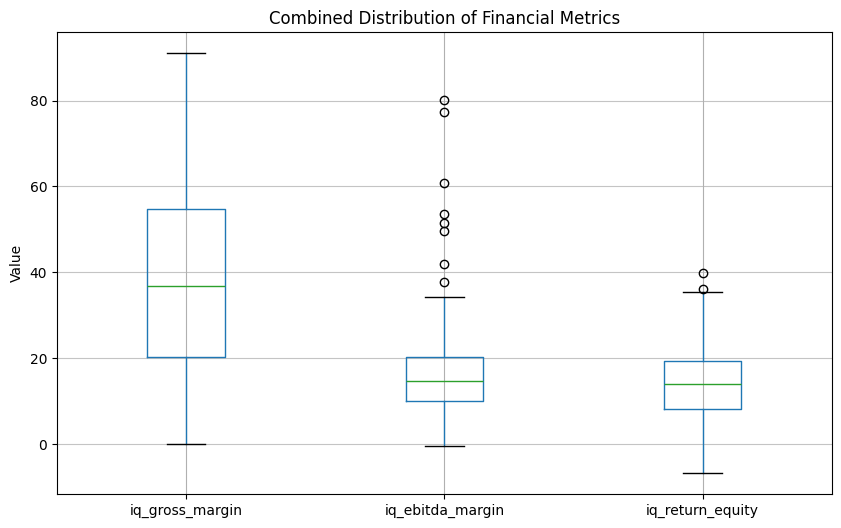

In [310]:
plot_combined_boxplot(cluster1_2011, ['iq_gross_margin', 'iq_ebitda_margin', 'iq_return_equity'])

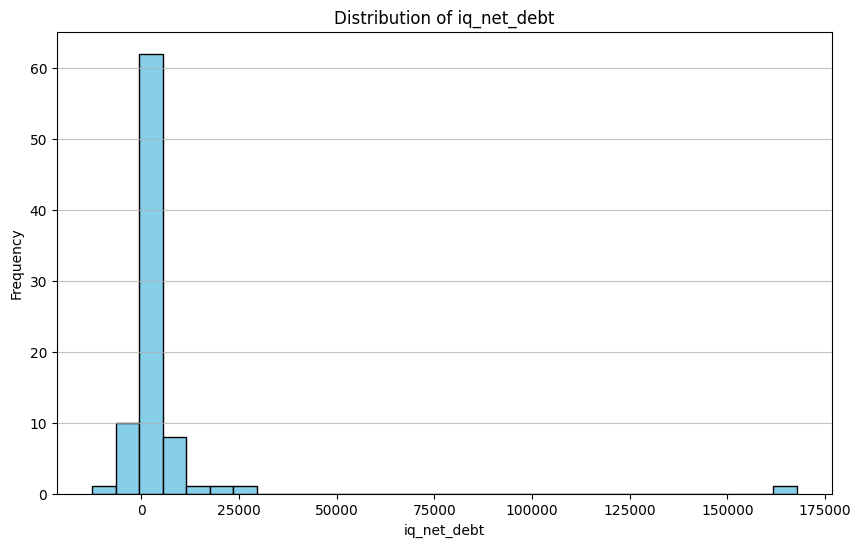

In [312]:
plot_financial_attribute_distribution(cluster1_2011, 'iq_net_debt')

### Cluster 1

In [313]:
financial_stats_by_node(cluster2_2011, financial_attributes, ratio_attributes)

Average       Min       Max    Variance
iq_capex                -3.42k    -8.09k    -0.20k       5.48k
iq_cash_oper             4.15k   -58.37k    38.84k     397.43k
iq_cogs                 53.37k     0.00k   181.94k    2308.24k
iq_cost_rev             55.92k     0.00k   181.94k    2466.93k
iq_curr_taxes            1.49k     0.00k     4.35k       1.40k
iq_gp                   21.87k     4.21k    39.64k      79.21k
iq_int_exp_ltd           0.62k     0.00k     5.66k       2.27k
iq_marketcap            50.56k    15.84k   166.96k    1717.92k
iq_net_debt              7.04k  -213.65k    70.88k    4582.81k
iq_ni                    4.84k    -2.22k    15.41k      16.70k
iq_oper_inc              7.21k     2.51k    13.52k       9.99k
iq_total_assets        436.20k    61.17k  2164.10k  366405.83k
iq_total_debt_capital    0.04k     0.00k     0.09k       0.00k
iq_total_equity         38.54k    14.48k    63.35k     193.44k
iq_total_liab          397.66k    35.79k  2109.44k  358872.59k
iq_total_rev            77.79k    25.74k   186.15k    2072.92k
iq_ni_margin             7.58%    -1.96%    21.18%      33.08%
iq_return_assets         3.59%     0.21%    13.79%      13.59%
iq_return_equity        16.75%    -4.40%    73.01%     300.82%
iq_total_debt_equity   151.90%     0.00%  1040.40%   60747.78%
iq_gross_margin         28.77%     0.00%    92.47%     638.89%

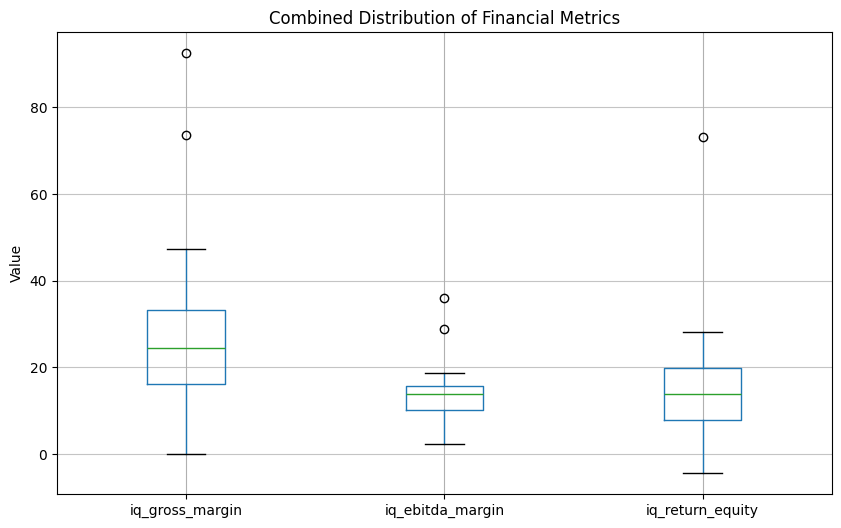

In [314]:
plot_combined_boxplot(cluster2_2011, ['iq_gross_margin', 'iq_ebitda_margin', 'iq_return_equity'])

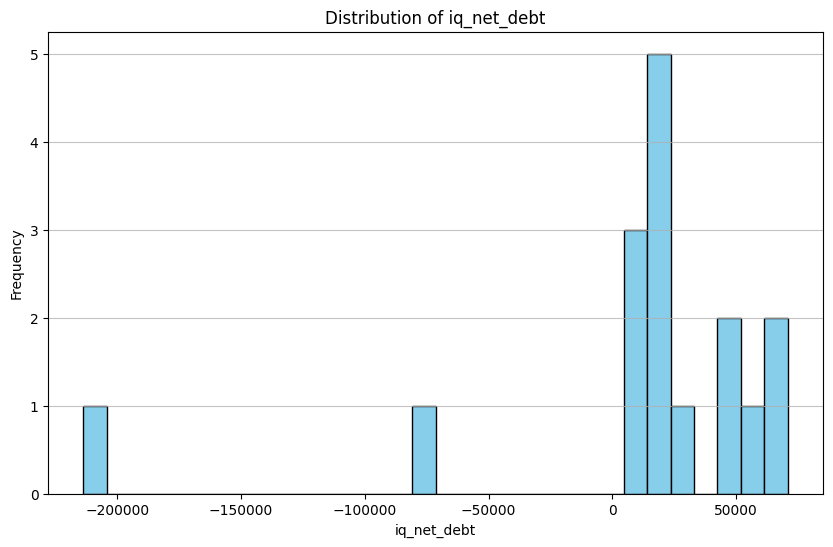

In [315]:
plot_financial_attribute_distribution(cluster2_2011, 'iq_net_debt')